In [1]:
import sys; sys.path.append("..")
from models.utils import *
from models.plotting_utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt

In [20]:
# data_home = "/mnt/g/My Drive/GTC/solodoch_data_minimal"
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"
lats = ["26N", "30S", "55S", "60S"]

In [21]:
lat = lats[3]
inputs = xr.open_dataset(f"{data_home}/solodoch_data_minimal/{lat}.nc")
inputs

<xarray.Dataset>
Dimensions:    (time: 288, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2015-12-16T12:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

In [22]:
outputs = xr.open_dataset(f"{data_home}/streamfunctions_ecco/{lat}/PSI_residual{lat}.nc")
outputs

<xarray.Dataset>
Dimensions:  (k: 50, lat: 1, time: 312)
Coordinates:
    Z        (k) float32 ...
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) int32 -60
  * time     (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    trsp_z   (time, k, lat) float64 ...
    psi_moc  (time, k, lat) float64 ...
    moc      (time, lat) float64 ...

In [23]:
date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range)

Date range to align to: ('1992-01-16', '2015-12-16')


In [24]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=True,
                              remove_trend=True,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["time"])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=True,
                               remove_trend=True,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np
y = strength_np

# shuffle data - don't think we want to do this!
# p = np.random.permutation(len(y))
# X, y = X[p], y[p]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (288, 5)

Inputs shape: (288, 5)
Outputs shape: (288,)


In [25]:
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
# add bias term
X = sm.add_constant(X)

# train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

# hyperparameters to optimise
param_grid = {
    "alpha": np.logspace(-4, 4, 10),
    "L1_wt": np.linspace(0, 1, 10)
}

# grid search - 10-fold cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# report best result
print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

# report test performance
y_pred = grid_search.best_estimator_.predict(X_test)
r2 = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")

Best MSE (cross-validation): 0.213
Test R^2: 0.992
Test MSE: 0.247


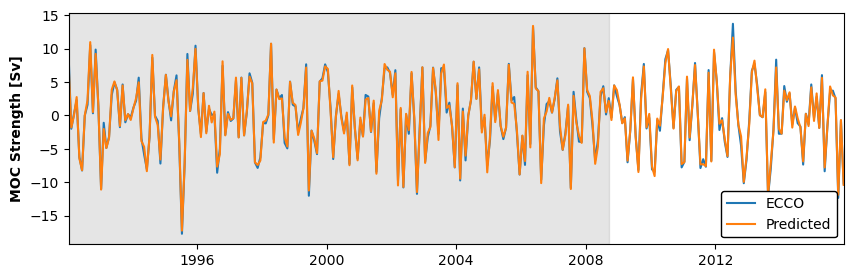

In [26]:
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

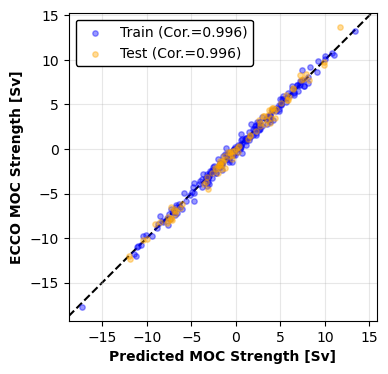

In [27]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
plt.show()